In [1]:
import os
from PIL import Image, UnidentifiedImageError

# проверка, являются ли файлы в директории изображениями
def check_images_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            try:
                img = Image.open(file_path)
            except UnidentifiedImageError:
                    print(file_path)

chosen_directory = "data"
check_images_in_directory(chosen_directory)

data\dataset\cat\666.jpg
data\dataset\cat\Thumbs.db
data\dataset\dog\11702.jpg


C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


data\dataset\dog\Thumbs.db


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# определение входной формы модели
input_shape = (150, 150, 3)

# загрузка предварительно обученной модели InceptionV3
base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

# заморозка весов
base_model.trainable = False

# определение архитектуры модели
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# подготовка данных для обучения и проверки модели
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/train', target_size=input_shape[:2], 
                                                    batch_size=32, class_mode='categorical', shuffle=False)
val_generator = val_datagen.flow_from_directory('data/validation', target_size=input_shape[:2], 
                                                batch_size=32, class_mode='categorical', shuffle=False)

# обучение модели
hist = model.fit(train_generator, epochs=10, validation_data=val_generator)

# сохранение обученной модели
model.save('trained_model.keras')

# загрузка сохраненной модели
loaded_model = tf.keras.models.load_model('trained_model.keras')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
63/63 [==============================] - 330s 5s/step - loss: 4.2676 - accuracy: 0.7880 - val_loss: 0.1940 - val_accuracy: 0.9445
Epoch 2/10
63/63 [==============================] - 307s 5s/step - loss: 0.1752 - accuracy: 0.9315 - val_loss: 0.1652 - val_accuracy: 0.9400
Epoch 3/10
63/63 [==============================] - 324s 5s/step - loss: 0.1500 - accuracy: 0.9390 - val_loss: 0.1421 - val_accuracy: 0.9450
Epoch 4/10
63/63 [==============================] - 384s 6s/step - loss: 0.1145 - accuracy: 0.9560 - val_loss: 0.1305 - val_accuracy: 0.9535
Epoch 5/10
63/63 [==============================] - 334s 5s/step - loss: 0.1104 - accuracy: 0.9545 - val_loss: 0.2262 - val_accuracy: 0.9075
Epoch 6/10
63/63 [==============================] - 302s 5s/step - loss: 0.1033 - accuracy: 0.9615 - val_loss: 0.1096 - val_accuracy: 0.9610
Epoch 7/10
63/63 [==============================] - 320s 5s/step - los

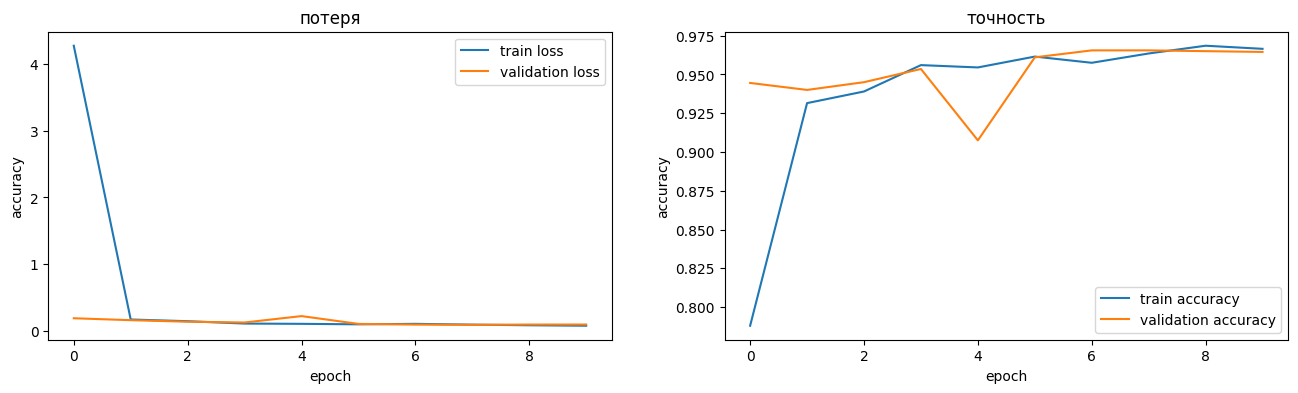

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

# визуализация потери модели при обучении и валидации
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.title('потеря')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

# визуализация точности модели при обучении и валидации
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title('точность')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

In [4]:
# классификация изображений с помощью загруженной модели
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test', target_size=input_shape[:2], 
                                                  batch_size=1, class_mode='categorical', shuffle=False)

predictions = loaded_model.predict(test_generator)

Found 2000 images belonging to 2 classes.
2000/2000 [==============================] - 312s 153ms/step


In [5]:
import pandas as pd

# оценка точности предсказаний модели на тестовых данных
val_score, val_acc = loaded_model.evaluate(val_generator)
test_score, test_acc = loaded_model.evaluate(test_generator)

model_acc = [('при валидации', val_score, val_acc), ('на тестовых данных', test_score, test_acc)]

predict_test = pd.DataFrame(data = model_acc, columns=['модель', 'потеря', 'точность'])
predict_test

2000/2000 [==============================] - 312s 156ms/step - loss: 0.0922 - accuracy: 0.9610


,модель,потеря,точность
0,при валидации,0.100102,0.9645
1,на тестовых данных,0.092233,0.9610


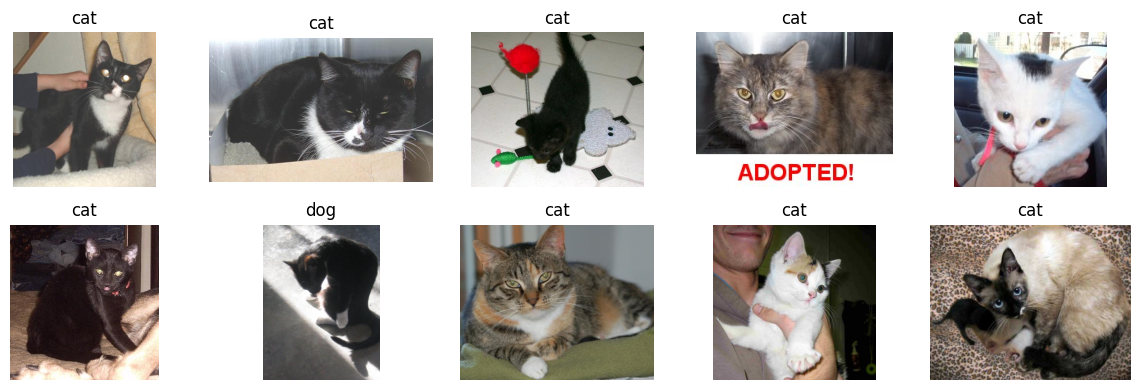

In [6]:
import numpy as np

# визуализация первых 10-ти предсказаний модели
num_rows = 2
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 4))

for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            
            class_labels = train_generator.class_indices
            inverse_labels = dict((v, k) for k, v in class_labels.items())
            predicted_class = inverse_labels[np.argmax(predictions[index])]
            
            img_path = 'data/test/' + test_generator.filenames[index]
            img = plt.imread(img_path)
            
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            ax[i, j].set_title(predicted_class)

plt.tight_layout()
plt.show()

1/1 [==============================] - 5s 5s/step


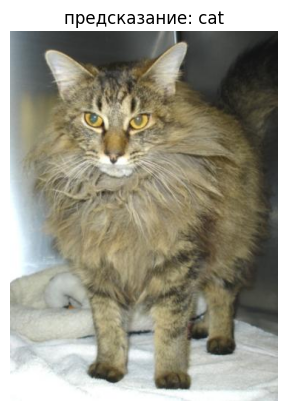

In [7]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# классификация одного изображения с помощью загруженной модели
def classify_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    
    x = img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    predictions = loaded_model.predict(x)
    class_labels = train_generator.class_indices
    inverse_labels = dict((v, k) for k, v in class_labels.items())
    predicted_class = inverse_labels[np.argmax(predictions)]
    
    return predicted_class

img_path = 'data/dataset/cat/12498.jpg'
predicted_class = classify_image(img_path)

image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.title(f'предсказание: {predicted_class}')

plt.show()